In [27]:
"""
r: Zongyi Li and Daniel Zhengyu Huang
"""

import numpy
import torch.nn.functional as F
import matplotlib.pyplot as plt
from timeit import default_timer
from catheter import *
from utilities3 import *
from Adam import Adam

torch.manual_seed(0)
np.random.seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("device is ", (device))

device is  cuda


In [28]:
def Lx2length(L_x, L_p, x1, x2, x3, h):
    l0, l1, l2, l3 = -x3, torch.sqrt((x2-x3)**2 + h**2), torch.sqrt((x1-x2)**2 + h**2), L_p+x1
    if L_x < -x3:
        l = L_x
    elif L_x < -x2:
        l = l0 + l1*(L_x + x3)/(x3-x2)
    elif L_x < -x1:
        l = l0 + l1 + l2*(L_x + x2)/(x2-x1)
    else:
        l = l0 + l1 + l2 + L_x+x1

    return l

def d2xy(d, L_p, x1, x2, x3, h):
    
    p0, p1, p2, p3 = torch.tensor([0.0,0.0]), torch.tensor([x3,0.0]), torch.tensor([x2, h]), torch.tensor([x1,0.0])
    v0, v1, v2, v3 = torch.tensor([x3-0,0.0]), torch.tensor([x2-x3,h]), torch.tensor([x1-x2,-h]), torch.tensor([-L_p-x1,0.0])
    l0, l1, l2, l3 = -x3, torch.sqrt((x2-x3)**2 + h**2), torch.sqrt((x1-x2)**2 + h**2), L_p+x1
    
    xx, yy = torch.zeros(d.shape), torch.zeros(d.shape)
    ind = (d < l0)
    xx[ind] = d[ind]*v0[0]/l0 + p0[0]
    yy[ind] = d[ind]*v0[1]/l0 + p0[1]
    
    ind = torch.logical_and(d < l0 + l1, d>=l0)
    xx[ind] = (d[ind]-l0)*v1[0]/l1 + p1[0] 
    yy[ind] = (d[ind]-l0)*v1[1]/l1 + p1[1]
    
    ind = torch.logical_and(d < l0 + l1 + l2, d>=l0 + l1)
    xx[ind] = (d[ind]-l0-l1)*v2[0]/l2 + p2[0]
    yy[ind] = (d[ind]-l0-l1)*v2[1]/l2 + p2[1]
    
    ind = (d>=l0 + l1 + l2)
    xx[ind] = (d[ind]-l0-l1-l2)*v3[0]/l3 + p3[0]
    yy[ind] = (d[ind]-l0-l1-l2)*v3[1]/l3 + p3[1]
    

    return xx, yy

def catheter_mesh_1d_total_length(L_x, L_p, x2, x3, h, N_s):
    x1 = -0.5*L_p
    # ncy = 20
    
    n_periods = torch.floor(L_x / L_p)
    L_x_last_period = L_x - n_periods*L_p
    L_p_s = ((x1 + L_p) + (0 - x3) + torch.sqrt((x2 - x1)**2 + h**2) + torch.sqrt((x3 - x2)**2 + h**2))
    L_s = L_p_s*n_periods + Lx2length(L_x_last_period, L_p, x1, x2, x3, h)
    
    # from 0
    d_arr = torch.linspace(0, 1, N_s) * L_s
    
    # TODO do not compute gradient for floor
    period_arr = torch.floor(d_arr / L_p_s).detach()
    d_arr -= period_arr * L_p_s

    
    xx, yy = d2xy(d_arr, L_p, x1, x2, x3, h)
        
    xx = xx - period_arr*L_p
    
    
    X_Y = torch.zeros((1, N_s, 2), dtype=torch.float).to(device)
    X_Y[0, :, 0], X_Y[0, :, 1] = xx, yy
    return X_Y, xx, yy




1d X error =  0.0005472336590786565
1d Y error =  0.00038736877123649244


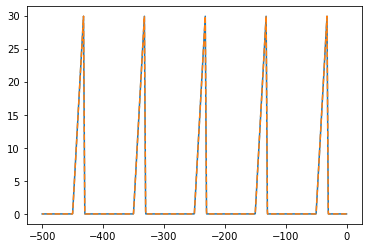

In [29]:
L_x, L_p, x2, x3, h = 500, 100, -32, -30, 30
x1 = -0.5*L_p
N_s = 1001
X0,Y0 = numpy_catheter_mesh_1d_total_length(L_x, L_p, x1, x2, x3, h, N_s)

L_p, x2, x3, h =  torch.tensor(L_p, dtype=torch.float), torch.tensor(x2, dtype=torch.float), torch.tensor(x3, dtype=torch.float), torch.tensor(h, dtype=torch.float)
X_Y, X, Y = catheter_mesh_1d_total_length(L_x, L_p, x2, x3, h, N_s)



print("1d X error = ", np.linalg.norm(X0 - X.cpu().numpy()))
print("1d Y error = ", np.linalg.norm(Y0 - Y.cpu().numpy()))
X_Y_numpy = X_Y.cpu().numpy()
plt.plot(X0, Y0)
plt.plot(X_Y_numpy[0, :, 0], X_Y_numpy[0, :, 1], "--")

# ##################################################
# # Prediction on a special design
# #################################################
# model = torch.load("catheter_plain_period_model_1d500", map_location=device)
# out = torch.clip(model(X_Y).squeeze(), min=0.0).detach().cpu().numpy()
# xx_mask = numpy.linspace(1.0, 0, n_periods*ncx+1) * (-L_p*n_periods)
# print("L_p, x1, x2, x3, h  = ", L_p, x1, x2, x3, h)
# print("loss = ",  -np.dot(out,xx_mask) )
# plt.figure()
# plt.plot(xx_mask, out)


[785.           5.03008     62.87507539 -31.43753769  -8.69985683
 -15.85508335  28.01017283]
sample =  785.0
min loss =  262913.0332581358 L_p, x2, x3, h =  tensor(62.8751) tensor(-8.6999) tensor(-15.8551) tensor(28.0102)
predicted loss:  258742.26043383864
4170.772824297205
0.24987506246876562


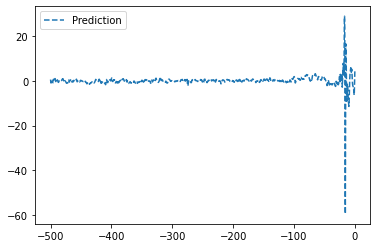

In [30]:
# All data design results
PATH = "/groups/esm/dzhuang/Catheter/allparam/length/"
INPUT_X = PATH+"x_1d_structured_mesh.npy"
INPUT_Y = PATH+"y_1d_structured_mesh.npy"
INPUT_para = PATH+"data_info.npy"
OUTPUT = PATH+"density_1d_data.npy"
n_data = 3000
inputX_raw = np.load(INPUT_X)[:, 0:n_data]
inputY_raw = np.load(INPUT_Y)[:, 0:n_data]
inputPara_raw = np.load(INPUT_para)[:, 0:n_data]
output_raw = np.load(OUTPUT)[:, 0:n_data]


# nx ny
L_x , N_s = 500.0, 2001

################################################################
# load data and data normalization
################################################################
inputX = inputX_raw[:, 0::3]
inputY = inputY_raw[:, 0::3]
inputPara = inputPara_raw[:, 0::3]
output = (output_raw[:, 0::3] + output_raw[:, 1::3] + output_raw[:, 2::3])/ 3.0


n_data = inputX.shape[1]
all_loss = np.zeros(n_data)


for i in range(n_data):
    
    sample, uf, L_p, x1, x2, x3, h = inputPara[:, i]
    xx_mask = numpy.linspace(1.0, 0, N_s) * (-L_x)
    all_loss[i] = -np.dot(output[:, i], xx_mask) * L_x/N_s

    

loss_min_ind = np.argmin(all_loss)
loss_min = all_loss[loss_min_ind]
sample, uf, L_p, x1, x2, x3, h = inputPara[:, loss_min_ind]

model = torch.load("catheter_plain_length_model_1d500", map_location=device)
L_p, x2, x3, h =  torch.tensor(L_p, dtype=torch.float), torch.tensor(x2, dtype=torch.float), torch.tensor(x3, dtype=torch.float), torch.tensor(h, dtype=torch.float)

X_Y, X, Y = catheter_mesh_1d_total_length(L_x, L_p, x2, x3, h, N_s)
out = model(X_Y).squeeze().detach().cpu().numpy()


print(inputPara[:, loss_min_ind])
print("sample = ", sample)
print("min loss = ", loss_min, "L_p, x2, x3, h = ", L_p, x2, x3, h)

xx_mask = numpy.linspace(1.0, 0, N_s) * (-L_x)
print("predicted loss: ", -np.dot(out, xx_mask) * L_x/N_s)

density = output[:, loss_min_ind]
mesh_X = inputX[:, loss_min_ind]
mesh_Y = inputY[:, loss_min_ind]
plt.figure()
# plt.plot(xx_mask, density, label="Reference")
plt.plot(xx_mask, out - density, "--", label="Prediction")
# plt.plot(mesh_X, mesh_Y)
plt.legend()

print(np.dot(out - density, xx_mask) * L_x/N_s)
print(L_x/N_s)

In [33]:
theta0 =    inv_transfer(L_p, x2, x3, h) 

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

1336001
initialize :  [ 1.32175584 -0.84729786  1.79175947  0.        ]
initialize :  (tensor(100., grad_fn=<AddBackward0>), tensor(-50., grad_fn=<MulBackward0>), tensor(-30., grad_fn=<AddBackward0>), tensor(-30., grad_fn=<AddBackward0>), tensor(25., grad_fn=<AddBackward0>))
gradient =  None
0 0.021556783467531204 loss =  540878.4375
L_p, x1, x2, x3, h  =  100.0 -50.0 -30.0 -30.0 25.0


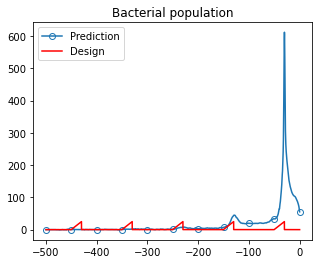

gradient =  tensor([-79443688.0000,  -2960485.0000,  -1142654.1250,   3093238.5000])
200 0.014664508402347565 loss =  529770.125
L_p, x1, x2, x3, h  =  99.09259033203125 -49.546295166015625 -30.342140197753906 -29.731351852416992 25.073440551757812


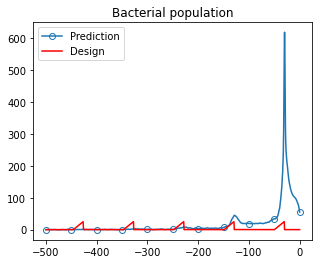

gradient =  tensor([-1.4581e+08, -7.3436e+06, -3.2628e+06,  6.5826e+06])
400 0.014619985595345497 loss =  519629.1875
L_p, x1, x2, x3, h  =  98.13140869140625 -49.065704345703125 -30.768295288085938 -29.458568572998047 25.155380249023438


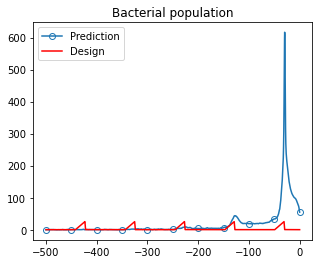

gradient =  tensor([-2.0310e+08, -1.3825e+07, -6.7780e+06,  1.0486e+07])
600 0.014740372076630592 loss =  511200.03125
L_p, x1, x2, x3, h  =  97.20824432373047 -48.604122161865234 -31.228187561035156 -29.20587921142578 25.23798942565918


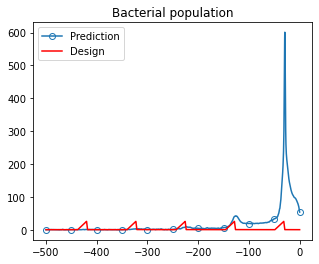

gradient =  tensor([-2.5365e+08, -2.1543e+07, -1.0299e+07,  1.5000e+07])
800 0.014781493693590164 loss =  505469.21875
L_p, x1, x2, x3, h  =  96.32049560546875 -48.160247802734375 -31.700538635253906 -28.955900192260742 25.320049285888672


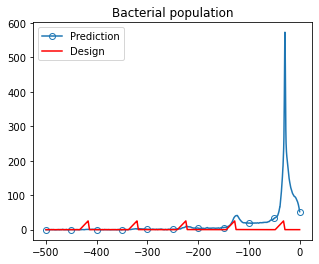

gradient =  tensor([-2.6053e+08, -3.1287e+07, -1.4218e+07,  2.0249e+07])
1000 0.014527689665555954 loss =  507549.71875
L_p, x1, x2, x3, h  =  95.5123291015625 -47.75616455078125 -32.184627532958984 -28.727333068847656 25.40210723876953


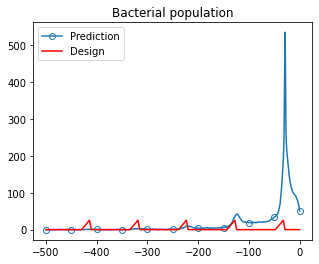

gradient =  tensor([-2.3318e+08, -4.2658e+07, -1.8107e+07,  2.5899e+07])
1200 0.014799319207668304 loss =  514180.09375
L_p, x1, x2, x3, h  =  94.8241958618164 -47.4120979309082 -32.69841766357422 -28.54083824157715 25.483224868774414


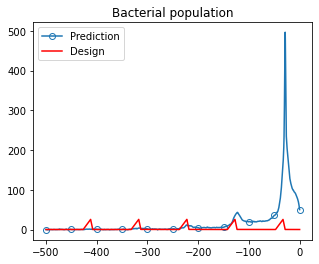

gradient =  tensor([-1.1651e+08, -5.7065e+07, -2.3854e+07,  3.1777e+07])
1400 0.014702392742037773 loss =  528201.3125
L_p, x1, x2, x3, h  =  94.28138732910156 -47.14069366455078 -33.255558013916016 -28.411073684692383 25.56279754638672


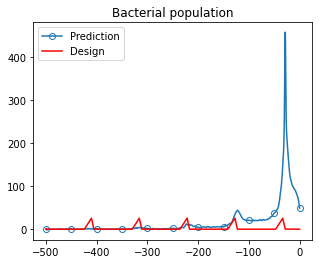

gradient =  tensor([ 2.5850e+08, -7.7682e+07, -3.5164e+07,  3.7732e+07])
1600 0.015920894220471382 loss =  522245.125
L_p, x1, x2, x3, h  =  94.66864013671875 -47.334320068359375 -34.16781234741211 -28.704059600830078 25.64032745361328


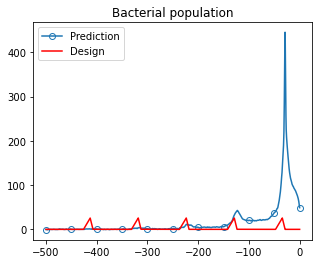

gradient =  tensor([ 2.9574e+08, -9.7670e+07, -4.0009e+07,  4.3572e+07])
1800 0.014694064855575562 loss =  521813.5625
L_p, x1, x2, x3, h  =  95.40155029296875 -47.700775146484375 -35.204219818115234 -29.138784408569336 25.71578598022461


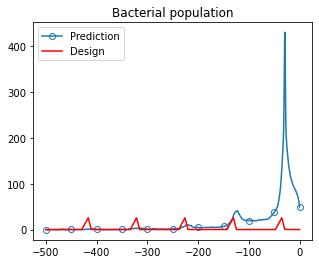

gradient =  tensor([ 3.0602e+08, -1.1889e+08, -4.4730e+07,  4.8956e+07])
2000 0.014852335676550865 loss =  525122.0
L_p, x1, x2, x3, h  =  96.14857482910156 -48.07428741455078 -36.243499755859375 -29.57110023498535 25.78884506225586


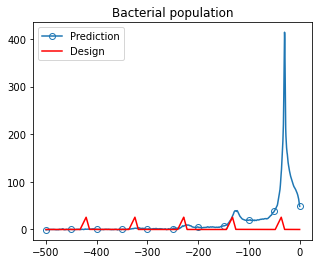

gradient =  tensor([ 2.7659e+08, -1.4018e+08, -4.8596e+07,  5.3664e+07])
2200 0.015269985422492027 loss =  534194.5
L_p, x1, x2, x3, h  =  96.84272766113281 -48.421363830566406 -37.25614547729492 -29.974130630493164 25.859176635742188


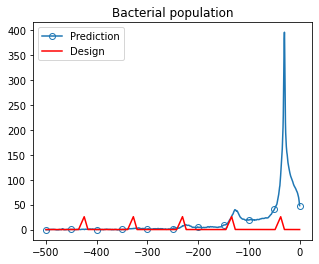

KeyboardInterrupt: 

In [39]:
################################################################
# inverse optimization for 1d
################################################################


model = torch.load("catheter_plain_length_model_1d1000", map_location=device)
print(count_params(model))

learning_rate = 0.0001
epochs = 5001
step_size = 1000
gamma = 1.0

# learning_rate = 0.001
# epochs = 5001
# step_size = 500
# gamma = 0.5

# constraints   
#               60 < L_p < 250
#               x1 = -0.5L_p 
#               -L_p/4 < x2 - x1 < L_p/4
#               15 < x3 - x1 < L_p/4
#               20 < h < 30
# def transfer(theta):
    
#     L_p = 60 + (250 - 60)/(1 + torch.abs(theta[0]))
#     x1 = -0.5*L_p
#     x2 = x1  - L_p/4 + (L_p/2)/(1 + torch.abs(theta[1]))
#     x3 = x1  + 15 + (L_p/4 - 15)/(1 + torch.abs(theta[2]))
#     h = 20   + (10)/(1 + torch.abs(theta[3]))
#     return L_p, x1, x2, x3, h

# def inv_transfer(L_p, x2, x3, h):
#     x1 = -0.5*L_p
#     theta = np.zeros(4)
#     theta[0] = (250 - 60)/(L_p - 60) - 1
#     theta[1] = (L_p/2)/(x2 - x1  + L_p/4) - 1
#     theta[2] = (L_p/4 - 15)/(x3 - x1  - 15) - 1
#     theta[3] = 10/(h - 20 ) - 1
#     return theta


# constraints   
#               60 < L_p < 250
#               x1 = -0.5L_p 
#               
#               15 < x3 - x1 < L_p/2
#.            -L_p < x2      < 0
#               20 < h       < 30
# def transfer(theta):
def transfer(theta):
    
    L_p = 60 + (250 - 60)/(1 + torch.exp(theta[0]))
    x1 = -0.5*L_p
    x3 = x1  + 15 + (L_p/2 - 15)/(1 + torch.exp(theta[2]))
    x2 = -L_p  + L_p/(1 + torch.exp(theta[1]))
    h = 20   + (10)/(1 + torch.exp(theta[3]))
    return L_p, x1, x2, x3, h


def inv_transfer(L_p, x2, x3, h):
    x1 = -0.5*L_p
    theta = np.zeros(4)
    theta[0] = np.log( (250 - 60)/(L_p - 60) - 1 )
    theta[1] = np.log( L_p/(x2 + L_p) - 1 )
    theta[2] = np.log( (L_p/2 - 15)/(x3 - x1  - 15) - 1 )
    theta[3] = np.log( 10/(h - 20 ) - 1 )
    return theta

# sample, uf, L_p, x1, x2, x3, h = inputPara[:, loss_min_ind]
# L_p, x2, x3, h = 80.0, -22.0, -22.0, 28.0
L_p, x2, x3, h = 100.0, -30.0, -30.0, 25.0
# L_p, x2, x3, h = 61.0, -30.0, -12.5, 29.0
# x2, x3, h = 73.85438537597656, -9.479606628417969, -19.35201644897461, 27.60188102722168
theta0 =    inv_transfer(L_p, x2, x3, h) 
print("initialize : ", theta0)

theta = torch.tensor(theta0.astype(np.float32) , requires_grad=True)
print("initialize : ", transfer(theta))

optimizer = Adam([theta], lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

myloss = LpLoss(size_average=False)


L_x = 500
N_s = 2001
xx_mask = (torch.linspace(1.0, 0, N_s) * (-L_x)).to(device)
for ep in range(epochs):
    model.train()
    t1 = default_timer()
    
    L_p, x1, x2, x3, h = transfer(theta)
    x, XC, YC = catheter_mesh_1d_total_length(L_x, L_p, x2, x3, h, N_s)
    
#     out = torch.clip(model(x).squeeze(), min=0.0)
    # out = torch.clip(model(x).squeeze(), min=0.0)
    out = model(x).squeeze()
    # maximize negative mean
    loss = -torch.sum(torch.matmul(out, xx_mask))* L_x/N_s
    
    if ep%200==0:
        print("gradient = ", theta.grad)
        
    loss.backward()
    
        
    optimizer.step()
    scheduler.step()

    t2 = default_timer()
    
    if ep%200==0:
        print(ep, t2 - t1,  "loss = ", loss.item())

        mesh = x.detach().cpu().numpy()
        print("L_p, x1, x2, x3, h  = ", L_p.item(), x1.item(), x2.item(), x3.item(), h.item())
        
        
        plt.figure(figsize=(5,4))
        plt.title("Bacterial population")
        plt.plot(xx_mask.detach().cpu().numpy(), out.detach().cpu().numpy().T, "-o", fillstyle='none', markevery=len(xx_mask)//10, label="Prediction")
        plt.plot(mesh[0, :, 0], mesh[0, :, 1], color="r", label="Design")
        
        plt.legend()
        plt.show()
#         plt.savefig("Catheter."+str(ep).zfill(5)+".pdf")

# BFGS

1336001
initialize :  [ 1.32175584 -0.84729786  1.79175947  0.        ]
initialize :  (tensor(100., grad_fn=<AddBackward0>), tensor(-50., grad_fn=<MulBackward0>), tensor(-30., grad_fn=<AddBackward0>), tensor(-30., grad_fn=<AddBackward0>), tensor(25., grad_fn=<AddBackward0>))
0 4159.573610756546 loss =  239411.0 loss_min =  inf
tensor([ 2.8108, -0.6411,  1.8383, -0.2243], grad_fn=<CloneBackward0>)
L_p, x1, x2, x3, h  =  70.78126525878906 -35.39063262939453 -24.41933822631836 -17.592029571533203 25.558345794677734


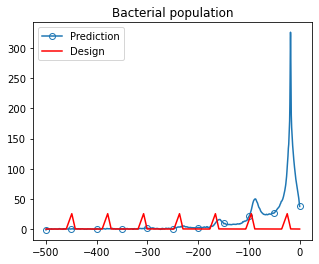

1 4159.991571366787 loss =  382444.59375 loss_min =  382444.59375
2 4160.223846837878 loss =  569953.4375 loss_min =  382444.59375
3 4160.452986316755 loss =  564899.4375 loss_min =  382444.59375
4 4160.700098719448 loss =  412657.40625 loss_min =  382444.59375
5 4160.931526999921 loss =  1024137.25 loss_min =  382444.59375
6 4161.180402304977 loss =  499292.625 loss_min =  382444.59375
7 4161.4311517272145 loss =  1122329.75 loss_min =  382444.59375
8 4161.644467191771 loss =  862103.875 loss_min =  382444.59375
tensor([ 2.7899, -1.3596,  2.3570, -1.5368], grad_fn=<CloneBackward0>)
L_p, x1, x2, x3, h  =  70.99557495117188 -35.49778747558594 -14.504966735839844 -18.724443435668945 28.229984283447266


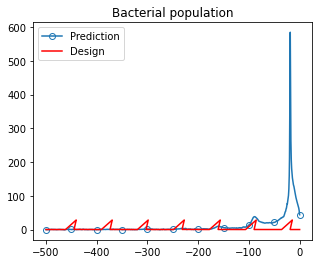

9 4162.050518333912 loss =  284737.5625 loss_min =  284737.5625
10 4162.280197557062 loss =  425696.40625 loss_min =  284737.5625
11 4162.508281342685 loss =  384984.46875 loss_min =  284737.5625
tensor([ 2.7495, -1.0715,  2.3494, -2.4513], grad_fn=<CloneBackward0>)
L_p, x1, x2, x3, h  =  71.42185974121094 -35.71092987060547 -18.221454620361328 -18.906770706176758 29.206558227539062


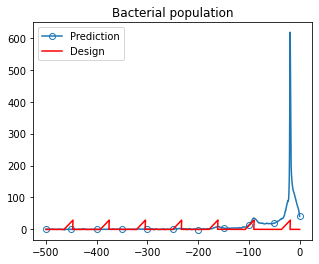

12 4162.912925263867 loss =  273305.46875 loss_min =  273305.46875
13 4163.125230407342 loss =  377903.53125 loss_min =  273305.46875
tensor([ 4.8071, -1.1069,  2.4121, -3.2176], grad_fn=<CloneBackward0>)
L_p, x1, x2, x3, h  =  61.54002380371094 -30.77001190185547 -15.289710998535156 -14.472907066345215 29.614910125732422


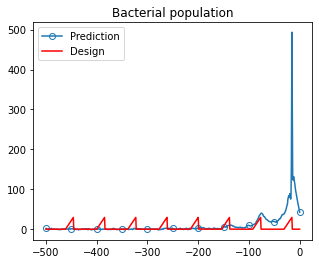

14 4163.51050809212 loss =  234737.9375 loss_min =  234737.9375
15 4163.741150204092 loss =  734538.0 loss_min =  234737.9375
16 4163.9552241154015 loss =  274003.59375 loss_min =  234737.9375
17 4164.182313179597 loss =  314301.53125 loss_min =  234737.9375
18 4164.396715315059 loss =  339850.9375 loss_min =  234737.9375
19 4164.626614166424 loss =  409775.65625 loss_min =  234737.9375
20 4164.853721162304 loss =  339066.0 loss_min =  234737.9375
21 4165.080904928967 loss =  283091.15625 loss_min =  234737.9375
22 4165.310846107081 loss =  401564.71875 loss_min =  234737.9375
23 4165.541694197804 loss =  345624.65625 loss_min =  234737.9375
24 4165.75421060808 loss =  354673.90625 loss_min =  234737.9375
tensor([ 5.0530, -1.2381,  2.2336, -3.8135], grad_fn=<CloneBackward0>)
L_p, x1, x2, x3, h  =  61.20637893676758 -30.60318946838379 -13.757633209228516 -14.093249320983887 29.784055709838867


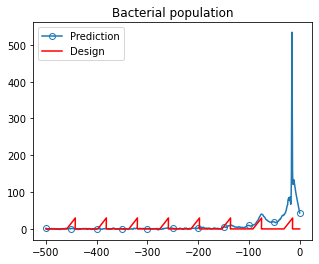

25 4166.142613571137 loss =  231400.953125 loss_min =  231400.953125
26 4166.37149954401 loss =  268918.21875 loss_min =  231400.953125
27 4166.616044227034 loss =  713389.875 loss_min =  231400.953125
28 4166.846657795832 loss =  540747.25 loss_min =  231400.953125
29 4167.058816730976 loss =  371384.0 loss_min =  231400.953125
30 4167.276769021526 loss =  247534.796875 loss_min =  231400.953125
31 4167.50385729596 loss =  246295.859375 loss_min =  231400.953125
32 4167.733553931117 loss =  482689.46875 loss_min =  231400.953125
33 4167.945269875228 loss =  252926.84375 loss_min =  231400.953125
34 4168.176562881097 loss =  233555.125 loss_min =  231400.953125
35 4168.407766247168 loss =  294860.65625 loss_min =  231400.953125
36 4168.6226496156305 loss =  555652.5 loss_min =  231400.953125
37 4168.8529359754175 loss =  373953.6875 loss_min =  231400.953125
38 4169.066082768142 loss =  245798.515625 loss_min =  231400.953125
39 4169.304396091029 loss =  251850.859375 loss_min =  23140

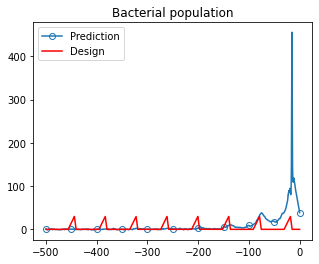

63 4174.9564176071435 loss =  225490.296875 loss_min =  225490.296875
64 4175.183225175366 loss =  229769.890625 loss_min =  225490.296875
65 4175.3951700516045 loss =  308367.75 loss_min =  225490.296875
tensor([ 5.5094, -0.9315,  4.0074, -3.6667], grad_fn=<CloneBackward0>)
L_p, x1, x2, x3, h  =  60.766109466552734 -30.383054733276367 -17.174072265625 -15.108386039733887 29.750770568847656


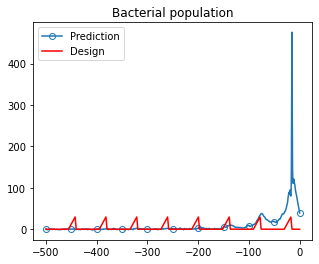

66 4175.777679022402 loss =  216802.203125 loss_min =  216802.203125
67 4176.023698631674 loss =  420672.5 loss_min =  216802.203125
68 4176.258927507326 loss =  315867.75 loss_min =  216802.203125
69 4176.470995454118 loss =  282673.53125 loss_min =  216802.203125
70 4176.702229158953 loss =  220731.890625 loss_min =  216802.203125
71 4176.916660474613 loss =  382018.875 loss_min =  216802.203125
72 4177.152200706303 loss =  360597.6875 loss_min =  216802.203125
73 4177.364968871698 loss =  326527.0625 loss_min =  216802.203125
74 4177.577977830544 loss =  227468.609375 loss_min =  216802.203125
75 4177.8076377715915 loss =  252654.171875 loss_min =  216802.203125
76 4178.020212324336 loss =  481932.78125 loss_min =  216802.203125
tensor([ 4.9766, -1.4687,  3.9199, -3.2269], grad_fn=<CloneBackward0>)
L_p, x1, x2, x3, h  =  61.30155563354492 -30.65077781677246 -11.471649169921875 -15.34625244140625 29.618356704711914


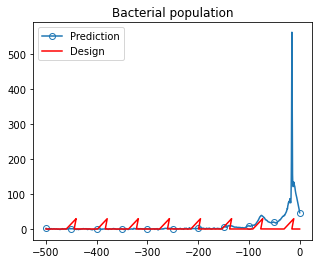

77 4178.410272793844 loss =  211834.140625 loss_min =  211834.140625
78 4178.645516706631 loss =  301902.5625 loss_min =  211834.140625
79 4178.876758066937 loss =  326948.71875 loss_min =  211834.140625
80 4179.1045591160655 loss =  471744.71875 loss_min =  211834.140625
81 4179.317225517705 loss =  372637.03125 loss_min =  211834.140625
82 4179.536176105961 loss =  256233.703125 loss_min =  211834.140625
83 4179.7482105866075 loss =  245002.5625 loss_min =  211834.140625
84 4179.973826553673 loss =  217869.234375 loss_min =  211834.140625
85 4180.211625427008 loss =  242401.5625 loss_min =  211834.140625
86 4180.427091525868 loss =  370662.15625 loss_min =  211834.140625
87 4180.65835869126 loss =  236046.734375 loss_min =  211834.140625
88 4180.88898537308 loss =  378759.53125 loss_min =  211834.140625
89 4181.10421958752 loss =  562710.8125 loss_min =  211834.140625
90 4181.316695703194 loss =  243333.6875 loss_min =  211834.140625
91 4181.543765095994 loss =  289896.375 loss_min =

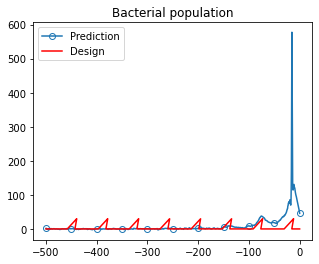

124 4189.006248386577 loss =  201779.3125 loss_min =  201779.3125
125 4189.226250866428 loss =  341827.78125 loss_min =  201779.3125
126 4189.441709022969 loss =  252475.6875 loss_min =  201779.3125
127 4189.679106673226 loss =  281376.65625 loss_min =  201779.3125
128 4189.909186467528 loss =  295488.1875 loss_min =  201779.3125
129 4190.121894136071 loss =  239850.234375 loss_min =  201779.3125
130 4190.318179715425 loss =  253486.6875 loss_min =  201779.3125
131 4190.548314075917 loss =  261571.71875 loss_min =  201779.3125
132 4190.775591559708 loss =  291358.6875 loss_min =  201779.3125
133 4191.00274967216 loss =  221150.015625 loss_min =  201779.3125
134 4191.22992657125 loss =  272681.8125 loss_min =  201779.3125
135 4191.460828207433 loss =  323235.90625 loss_min =  201779.3125
136 4191.676283443347 loss =  402843.71875 loss_min =  201779.3125
137 4191.8888881877065 loss =  225673.5 loss_min =  201779.3125
138 4192.103913895786 loss =  246386.828125 loss_min =  201779.3125
139

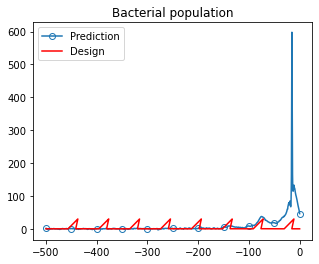

214 4209.026452627033 loss =  200901.265625 loss_min =  200901.265625
215 4209.24995274283 loss =  227569.359375 loss_min =  200901.265625
216 4209.489632414654 loss =  210248.375 loss_min =  200901.265625
217 4209.731897842139 loss =  639113.75 loss_min =  200901.265625
218 4209.981150299311 loss =  371615.0 loss_min =  200901.265625
219 4210.214933747426 loss =  288029.0 loss_min =  200901.265625
220 4210.449147583917 loss =  393998.21875 loss_min =  200901.265625
221 4210.697182847187 loss =  486324.90625 loss_min =  200901.265625
222 4210.929980520159 loss =  330187.875 loss_min =  200901.265625
223 4211.149746097624 loss =  284490.34375 loss_min =  200901.265625
224 4211.377837119624 loss =  478933.21875 loss_min =  200901.265625
225 4211.608261663467 loss =  672983.0 loss_min =  200901.265625
226 4211.823156218976 loss =  313388.5 loss_min =  200901.265625
227 4212.069286763668 loss =  207092.234375 loss_min =  200901.265625
228 4212.299826899543 loss =  260301.828125 loss_min = 

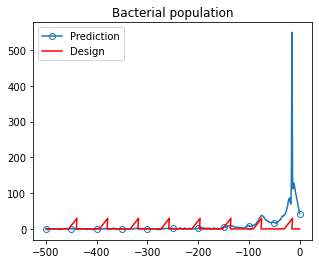

250 4217.2787920665 loss =  200206.828125 loss_min =  200206.828125
251 4217.508912650868 loss =  238142.875 loss_min =  200206.828125
252 4217.768780842423 loss =  442665.875 loss_min =  200206.828125
253 4217.907501384616 loss =  246205.0 loss_min =  200206.828125
254 4218.109139306471 loss =  201677.265625 loss_min =  200206.828125
255 4218.305937174708 loss =  394836.6875 loss_min =  200206.828125
256 4218.525774504989 loss =  208293.421875 loss_min =  200206.828125
257 4218.732775211334 loss =  338491.09375 loss_min =  200206.828125
258 4218.932777058333 loss =  401679.53125 loss_min =  200206.828125
259 4219.151765964925 loss =  327349.125 loss_min =  200206.828125
260 4219.369555782527 loss =  278483.96875 loss_min =  200206.828125
261 4219.569979161024 loss =  321147.125 loss_min =  200206.828125
262 4219.6954322028905 loss =  259066.46875 loss_min =  200206.828125
263 4219.918671451509 loss =  257998.0625 loss_min =  200206.828125
264 4220.115907955915 loss =  248708.65625 los

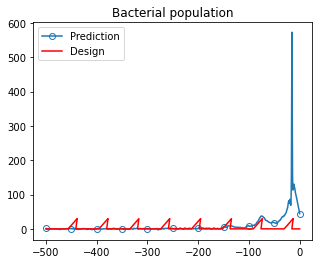

346 4235.8420113660395 loss =  199792.234375 loss_min =  199792.234375
347 4235.966408690438 loss =  423044.5 loss_min =  199792.234375
348 4236.180820081383 loss =  200737.71875 loss_min =  199792.234375
349 4236.405386814848 loss =  207174.40625 loss_min =  199792.234375
350 4236.532557491213 loss =  214869.515625 loss_min =  199792.234375
351 4236.756781447679 loss =  205140.03125 loss_min =  199792.234375
352 4236.995118673891 loss =  421175.5625 loss_min =  199792.234375
353 4237.193772645667 loss =  213953.390625 loss_min =  199792.234375
354 4237.335115050897 loss =  207522.234375 loss_min =  199792.234375
355 4237.477203654125 loss =  202635.875 loss_min =  199792.234375
356 4237.618384014815 loss =  581186.5 loss_min =  199792.234375
357 4237.752244651318 loss =  310406.5625 loss_min =  199792.234375
358 4237.895488183945 loss =  440037.15625 loss_min =  199792.234375
359 4238.036421054974 loss =  236831.578125 loss_min =  199792.234375
360 4238.251012407243 loss =  288555.062

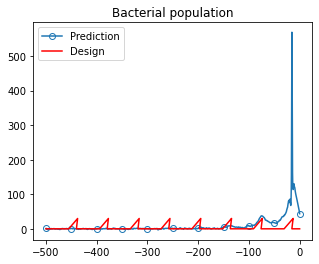

396 4245.559878729284 loss =  199451.484375 loss_min =  199451.484375
397 4245.703362951055 loss =  219329.5 loss_min =  199451.484375
398 4245.848339699209 loss =  503428.8125 loss_min =  199451.484375
399 4245.9914803132415 loss =  345672.28125 loss_min =  199451.484375
400 4246.228706602007 loss =  290484.25 loss_min =  199451.484375
401 4246.369892643765 loss =  268061.96875 loss_min =  199451.484375
tensor([ 5.4862, -1.2754,  6.3596, -5.8059], grad_fn=<CloneBackward0>)
L_p, x1, x2, x3, h  =  60.78401565551758 -30.39200782775879 -13.271270751953125 -15.365426063537598 29.969993591308594


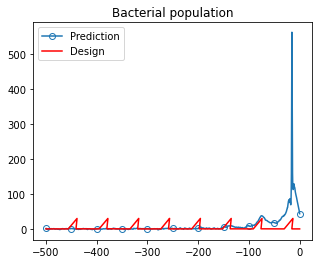

402 4246.788640895858 loss =  199362.0 loss_min =  199362.0
403 4247.054827287793 loss =  419967.46875 loss_min =  199362.0
404 4247.195964934304 loss =  225194.3125 loss_min =  199362.0
405 4247.338633518666 loss =  200776.59375 loss_min =  199362.0
406 4247.481808114797 loss =  239497.328125 loss_min =  199362.0
407 4247.775930888951 loss =  443871.90625 loss_min =  199362.0
408 4248.050600498915 loss =  300415.71875 loss_min =  199362.0
409 4248.328966317698 loss =  314065.96875 loss_min =  199362.0
410 4248.6034749001265 loss =  233360.828125 loss_min =  199362.0
411 4248.8657948076725 loss =  274527.625 loss_min =  199362.0
412 4249.160058360547 loss =  202560.609375 loss_min =  199362.0
413 4249.4354609344155 loss =  264306.125 loss_min =  199362.0
414 4249.730477178469 loss =  216292.734375 loss_min =  199362.0
415 4250.036989666522 loss =  309982.75 loss_min =  199362.0
416 4250.316102718934 loss =  204462.75 loss_min =  199362.0
417 4250.610329050571 loss =  222271.453125 loss

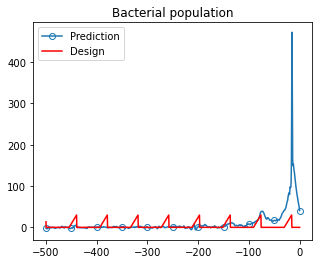

441 4257.462019395083 loss =  198015.5 loss_min =  198015.5
442 4257.73740651831 loss =  544840.9375 loss_min =  198015.5
443 4258.012337058783 loss =  236391.234375 loss_min =  198015.5
444 4258.287121582776 loss =  207688.71875 loss_min =  198015.5
445 4258.581191021949 loss =  346886.90625 loss_min =  198015.5
446 4258.859674476087 loss =  409257.53125 loss_min =  198015.5
447 4259.125408643857 loss =  720436.0625 loss_min =  198015.5
448 4259.420147052035 loss =  336447.53125 loss_min =  198015.5
449 4259.6996778119355 loss =  334698.46875 loss_min =  198015.5
450 4259.9758834932 loss =  528885.3125 loss_min =  198015.5
451 4260.271743146703 loss =  238526.421875 loss_min =  198015.5
452 4260.571287417784 loss =  287502.40625 loss_min =  198015.5
453 4260.872665382922 loss =  351223.375 loss_min =  198015.5
454 4261.16254908964 loss =  403586.65625 loss_min =  198015.5
455 4261.460648555309 loss =  471034.9375 loss_min =  198015.5
456 4261.741895236075 loss =  320213.28125 loss_min

In [79]:
################################################################
# inverse optimization for 1d
################################################################
torch.manual_seed(0)
np.random.seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

model = torch.load("catheter_plain_length_model_1d1000", map_location=device)
print(count_params(model))


epochs = 500

# constraints   
#               60 < L_p < 250
#               x1 = -0.5L_p 
#               
#               15 < x3 - x1 < L_p/2
#             -L_p < x2      < 0
#               20 < h       < 30
# def transfer(theta):
def transfer(theta):
    
    L_p = 60 + (250 - 60)/(1 + torch.exp(theta[0]))
    x1 = -0.5*L_p
    x3 = x1  + 15 + (L_p/2 - 15)/(1 + torch.exp(theta[2]))
    x2 = -L_p  + L_p/(1 + torch.exp(theta[1]))
    h = 20   + (10)/(1 + torch.exp(theta[3]))
    return L_p, x1, x2, x3, h


def inv_transfer(L_p, x2, x3, h):
    x1 = -0.5*L_p
    theta = np.zeros(4)
    theta[0] = np.log( (250 - 60)/(L_p - 60) - 1 )
    theta[1] = np.log( L_p/(x2 + L_p) - 1 )
    theta[2] = np.log( (L_p/2 - 15)/(x3 - x1  - 15) - 1 )
    theta[3] = np.log( 10/(h - 20 ) - 1 )
    return theta

# sample, uf, L_p, x1, x2, x3, h = inputPara[:, loss_min_ind]
# L_p, x2, x3, h = 80.0, -22.0, -22.0, 28.0
L_p, x2, x3, h = 100.0, -30.0, -30.0, 25.0
# L_p, x2, x3, h = 61.0, -30.0, -12.5, 29.0
# x2, x3, h = 73.85438537597656, -9.479606628417969, -19.35201644897461, 27.60188102722168
theta0 =    inv_transfer(L_p, x2, x3, h) 
print("initialize : ", theta0)

theta = torch.tensor(theta0.astype(np.float32) , requires_grad=True)
print("initialize : ", transfer(theta))


L_x = 500
N_s = 2001
xx_mask = (torch.linspace(1.0, 0, N_s) * (-L_x)).to(device)

max_iter = 100

optimizer = torch.optim.LBFGS([theta], max_iter=max_iter, lr=1.0, line_search_fn="strong_wolfe")

loss_min = torch.tensor(np.inf)
theta_min = torch.clone(theta)

for ep in range(epochs):
    t1 = default_timer()
    def loss_closure():
        
        L_p, x1, x2, x3, h = transfer(theta)
        
        x, XC, YC = catheter_mesh_1d_total_length(L_x, L_p, x2, x3, h, N_s)
    
        optimizer.zero_grad()
        out = model(x).squeeze()
        loss = -torch.sum(torch.matmul(out, xx_mask))* L_x/N_s
        loss.backward()
        
        return loss
    
    
    optimizer.step(loss_closure)

    t2 = default_timer()
 
    if ep%1==0:
        
        L_p, x1, x2, x3, h = transfer(theta)
        x, XC, YC = catheter_mesh_1d_total_length(L_x, L_p, x2, x3, h, N_s)
        out = model(x).squeeze()
        loss = -torch.sum(torch.matmul(out, xx_mask))* L_x/N_s
        print(ep, t2 - t1,  "loss = ", loss.item(), "loss_min = ", loss_min.item(),)
        
#         plt.savefig("Catheter."+str(ep).zfill(5)+".pdf")
        
        if loss < loss_min:
            
            theta_min = torch.clone(theta)
            loss_min = loss
            print(theta_min)
            mesh = x.detach().cpu().numpy()
            print("L_p, x1, x2, x3, h  = ", L_p.item(), x1.item(), x2.item(), x3.item(), h.item())


            plt.figure(figsize=(5,4))
            plt.title("Bacterial population")
            plt.plot(xx_mask.detach().cpu().numpy(), out.detach().cpu().numpy().T, "-o", fillstyle='none', markevery=len(xx_mask)//10, label="Prediction")
            plt.plot(mesh[0, :, 0], mesh[0, :, 1], color="r", label="Design")

            plt.legend()
            plt.show()
            
        theta = theta_min + torch.normal(mean=0.0, std=torch.ones(len(theta)))

In [76]:
torch.manual_seed(0)
np.random.seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

torch.normal(mean=0.0, std=torch.ones(len(theta)))

tensor([ 1.5410, -0.2934, -2.1788,  0.5684])

In [71]:
loss_min

tensor(203494.2188, device='cuda:0', grad_fn=<DivBackward0>)

In [21]:
################################################################
# inverse optimization for 1d
################################################################



L_x = 500
N_s = 2001
xx_mask = (torch.linspace(1.0, 0, N_s) * (-L_x)).to(device)
# learning_rate = 0.001
# epochs = 5001
# step_size = 500
# gamma = 0.5

# constraints   
#               60 < L_p < 250
#               x1 = -0.5L_p 
#               -L_p/4 < x2 - x3 < L_p/4
#               15 < x3 - x1 < L_p/4
#               20 < h < 30

loss_min = np.inf
L_p_min, x2_min, x3_min = np.NaN, np.NaN, np.NaN
mesh_min = np.NaN
density_min = np.NaN
nLp = 190
for L_p in np.linspace(60, 62, 20+1):
    print("L_p = ", L_p)
    x1 = -L_p/2
    for dx3_x1 in np.linspace(15, L_p/2, np.int64(np.round((L_p/2 - 15)))+1):
        print("dx3_x1 = ", dx3_x1)
        x3 = x1 + dx3_x1
        for h in np.linspace(29, 30, 11):
            for x2 in np.linspace(-L_p, 0, np.int64(np.round(L_p))+1):
            
                
                XC, YC = numpy_catheter_mesh_1d_total_length(L_x, L_p, x1, x2, x3, h, N_s)
                x = torch.tensor(np.vstack((XC,YC)).transpose()[np.newaxis, : ,:], dtype=torch.float).to(device) 
                
#                 L_p, x2, x3, h =  torch.tensor(L_p, dtype=torch.float), torch.tensor(x2, dtype=torch.float), torch.tensor(x3, dtype=torch.float), torch.tensor(h, dtype=torch.float)
#                 xx, XC, YC = catheter_mesh_1d_total_length(L_x, L_p, x2, x3, h, N_s)
#                 print(x - xx)
                out = model(x).squeeze()
                loss = -torch.sum(torch.matmul(out, xx_mask))* L_x/N_s
                if loss < loss_min:
                    L_p_min, x2_min, x3_min, h_min = L_p, x2, x3, h
                    mesh_min = np.copy(x.detach().cpu().numpy())
                    density_min = np.copy(out.detach().cpu().numpy())
                    loss_min = loss
                    print(L_p_min, x2_min, x3_min, h_min, loss_min)
                
plt.figure(figsize=(5,4))
plt.title("Bacterial population")
plt.plot(xx_mask.detach().cpu().numpy(), density_min, "-o", fillstyle='none', markevery=len(xx_mask)//10, label="Prediction")
plt.plot(mesh_min[0, :, 0], mesh_min[0, :, 1], color="r", label="Design")

plt.legend()
plt.show()



L_p =  60.0
dx3_x1 =  15.0
60.0 -60.0 -15.0 25.0 tensor(1163177.6250, device='cuda:0', grad_fn=<DivBackward0>)
60.0 -60.0 -15.0 26.0 tensor(1146735.1250, device='cuda:0', grad_fn=<DivBackward0>)
60.0 -60.0 -15.0 27.0 tensor(1127114.6250, device='cuda:0', grad_fn=<DivBackward0>)
60.0 -60.0 -15.0 28.0 tensor(1108573.5000, device='cuda:0', grad_fn=<DivBackward0>)
60.0 -60.0 -15.0 29.0 tensor(1086953.7500, device='cuda:0', grad_fn=<DivBackward0>)
60.0 -60.0 -15.0 30.0 tensor(1062519.3750, device='cuda:0', grad_fn=<DivBackward0>)
60.0 -59.0 -15.0 30.0 tensor(1058539.2500, device='cuda:0', grad_fn=<DivBackward0>)
60.0 -58.0 -15.0 30.0 tensor(1051428.2500, device='cuda:0', grad_fn=<DivBackward0>)
60.0 -57.0 -15.0 30.0 tensor(1041059.6250, device='cuda:0', grad_fn=<DivBackward0>)
60.0 -56.0 -15.0 30.0 tensor(1029130.6250, device='cuda:0', grad_fn=<DivBackward0>)
60.0 -55.0 -15.0 30.0 tensor(1016953.6875, device='cuda:0', grad_fn=<DivBackward0>)
60.0 -54.0 -15.0 30.0 tensor(1005137.5625, device

KeyboardInterrupt: 